References
* https://www.kaggle.com/code/yasufuminakama/fb3-deberta-v3-base-baseline-train
* https://www.kaggle.com/code/yasufuminakama/fb3-deberta-v3-base-baseline-inference

# # Weight Tuning Guideline

In [1]:
class CFG:
    DEBUG = True
    file_name="002"
    model = "lgbm"
    target_cols=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

In [2]:
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import string
import pickle
import random
import joblib
import itertools
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

import tensorflow as tf
print(f'TF version: {tf.__version__}')
import tensorflow_addons as tfa
from tensorflow.keras import layers

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import DataCollatorWithPadding
%env TOKENIZERS_PARALLELISM=false

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TF version: 2.6.4
tokenizers.__version__: 0.12.1
transformers.__version__: 4.20.1
env: TOKENIZERS_PARALLELISM=false


In [3]:
import os
import datetime
import pickle
import glob

# ====================================================
# datetime
# ====================================================
t_delta = datetime.timedelta(hours=9)
JST = datetime.timezone(t_delta, 'JST')
now = datetime.datetime.now(JST)
date = now.strftime('%Y%m%d')
date2 = now.strftime('%Y%m%d%H%M')


# ====================================================
# file_path
# ====================================================
if "/" in CFG.model:
    model_name = CFG.model.replace("/","-")
else:
    model_name = CFG.model

path ="/home/jupyter/feedback-prize-english-language-learning/"
if CFG.DEBUG:
    OUTPUT_DIR = f'/home/jupyter/output/ex/DEBUG/{model_name}/{CFG.file_name}/{date2}/'
else:
    OUTPUT_DIR = f'/home/jupyter/output/ex/{model_name}/{CFG.file_name}/{date2}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

#　データセット

In [4]:
os.system(f'kaggle kernels output hiroki8383/001-lgbm -p {OUTPUT_DIR}')

Output file downloaded to /home/jupyter/output/ex/DEBUG/lgbm/002/202211081859/001_lgbm_train.csv
Output file downloaded to /home/jupyter/output/ex/DEBUG/lgbm/002/202211081859/inference.log
Kernel log downloaded to /home/jupyter/output/ex/DEBUG/lgbm/002/202211081859/001-lgbm.log 


0

# Utils

In [5]:
# ====================================================
# Utils
# ====================================================
def MCRMSE(y_trues, y_preds):
    scores = []
    idxes = y_trues.shape[1]
    for i in range(idxes):
        y_true = y_trues[:,i]
        y_pred = y_preds[:,i]
        score = mean_squared_error(y_true, y_pred, squared=False) # RMSE
        scores.append(score)
    mcrmse_score = np.mean(scores)
    return mcrmse_score, scores

def get_score(y_trues, y_preds):
    mcrmse_score, scores = MCRMSE(y_trues, y_preds)
    return mcrmse_score, scores

def get_logger(filename='inference'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# LGBM 学習率を調整する

In [29]:
CFG.DEBUG = False

In [30]:
train = pd.read_csv(OUTPUT_DIR+"001_lgbm_train.csv")
if CFG.DEBUG:
    train = train.head(10)
    
model_num = int((train.shape[1]-9)/len(CFG.target_cols)) #9はtext_id,text,fold,target

In [37]:
import lightgbm as lgb
import joblib


params = {
    'task': 'train',              # タスクを訓練に設定
    'boosting_type': 'gbdt',      # GBDTを指定
    'objective': 'regression',    # 回帰を指定
    'metric': 'rmse',             # 回帰の損失（誤差）
    'learning_rate': 0.0001,         # 学習率
    'seed': 99,                  # シード値
    'device':'gpu'
      }

best_params = dict()
pred_cols2 = []
results = dict()
for t in CFG.target_cols:
    lgb_results = dict()
    for fold in range(train.fold.nunique()):
        pred_cols = [f"{t}_pred_{i}" for i in range(model_num) for t in CFG.target_cols]

        train_set = lgb.Dataset(train.loc[train.fold!=fold,pred_cols]\
                                    ,train.loc[train.fold!=fold,t])
        val_set = lgb.Dataset(train.loc[train.fold==fold,pred_cols]\
                                    ,train.loc[train.fold==fold,t])
        # Train and evaluate
        lgb_result = {} 
        model = lgb.train(
          params, 
          train_set, 
          num_boost_round = 100000, # 10000 
          early_stopping_rounds = 300, 
          valid_sets = [train_set, val_set], 
          verbose_eval = 1000,
          evals_result = lgb_result,
        )
        lgb_results[fold] = lgb_result
        best_params[fold] = model.params
        model_path = OUTPUT_DIR+f"lgb_fold{fold}.pkl"
        joblib.dump(model, model_path)
        tt = joblib.load(model_path)
        
        preds = tt.predict(train.loc[train.fold==fold,pred_cols])
        preds = np.clip(preds,1,5)
        train.loc[train.fold==fold,f"pred_{t}"] = preds
    pred_cols2.append(f"pred_{t}")
    results[t] = lgb_results
    break
train.to_pickle(OUTPUT_DIR+f'oof_df.pkl')   
score, scores = get_score(train[pred_cols2].to_numpy(), train[CFG.target_cols].to_numpy())
LOGGER.info(f'Model: "stacking_lgbm" Score: {score:<.4f}  Scores: {scores}')

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 10710
[LightGBM] [Info] Number of data points in the train set: 2933, number of used features: 42
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 42 dense feature groups (0.12 MB) transferred to GPU in 0.000812 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 3.122741
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.663766	valid_1's rmse: 0.644732
[200]	training's rmse: 0.660334	valid_1's rmse: 0.641603
[300]	training's rmse: 0.656948	valid_1's rmse: 0.638542
[400]	training's rmse: 0.653609	valid_1's rmse: 0.635541
[500]	training's rmse: 0.650318	valid_1's rmse: 0.632592
[600]	training's rmse: 0.647075	valid_1's rmse: 0.629691
[700]	training's rmse: 0.643878

Model: "stacking_lgbm" Score: 0.4862  Scores: [0.4862090497554261]


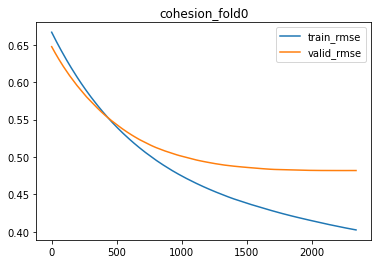

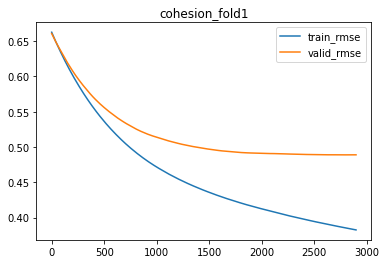

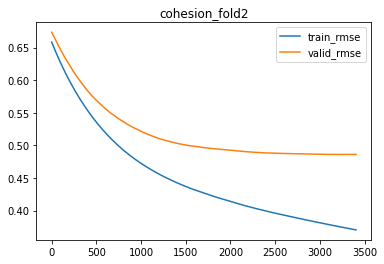

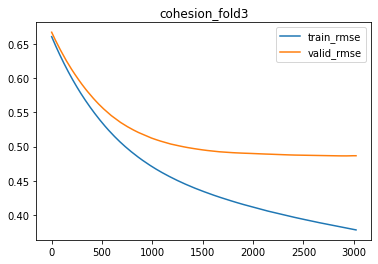

KeyError: 'syntax'

<Figure size 432x288 with 0 Axes>

In [35]:
for t in CFG.target_cols:
    for fold in range(train.fold.nunique()):
        fig = plt.figure()
        plt.plot(results[t][fold]["training"]["rmse"],label="train_rmse")
        plt.plot(results[t][fold]["valid_1"]["rmse"],label="valid_rmse")
        plt.title(f"{t}_fold{fold}")
        plt.legend()
        plt.show()

In [41]:
import lightgbm as lgb
import joblib


params = {
    'task': 'train',              # タスクを訓練に設定
    'boosting_type': 'gbdt',      # GBDTを指定
    'objective': 'regression',    # 回帰を指定
    'metric': 'rmse',             # 回帰の損失（誤差）
    'learning_rate': 0.0001,         # 学習率
    'seed': 99,                  # シード値
    'device':'gpu',
    "num_boost_round":100000,
    "early_stopping_rounds":300,
    'max_depth':5,
      }

best_params = dict()
pred_cols2 = []
results = dict()
for t in CFG.target_cols:
    lgb_results = dict()
    for fold in range(train.fold.nunique()):
        pred_cols = [f"{t}_pred_{i}" for i in range(model_num) for t in CFG.target_cols]

        train_set = lgb.Dataset(train.loc[train.fold!=fold,pred_cols]\
                                    ,train.loc[train.fold!=fold,t])
        val_set = lgb.Dataset(train.loc[train.fold==fold,pred_cols]\
                                    ,train.loc[train.fold==fold,t])
        # Train and evaluate
        lgb_result = {} 
        model = lgb.train(
          params, 
          train_set, 
          #num_boost_round = 100000, # 10000 
          #early_stopping_rounds = 300, 
          valid_sets = [train_set, val_set], 
          verbose_eval = 1000,
          evals_result = lgb_result,
        )
        lgb_results[fold] = lgb_result
        best_params[fold] = model.params
        model_path = OUTPUT_DIR+f"lgb_fold{fold}.pkl"
        joblib.dump(model, model_path)
        tt = joblib.load(model_path)
        
        preds = tt.predict(train.loc[train.fold==fold,pred_cols])
        preds = np.clip(preds,1,5)
        train.loc[train.fold==fold,f"pred_{t}"] = preds
        break
    pred_cols2.append(f"pred_{t}")
    results[t] = lgb_results
    break
train.to_pickle(OUTPUT_DIR+f'oof_df.pkl')   
score, scores = get_score(train[pred_cols2].to_numpy(), train[CFG.target_cols].to_numpy())
LOGGER.info(f'Model: "stacking_lgbm" Score: {score:<.4f}  Scores: {scores}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 10710
[LightGBM] [Info] Number of data points in the train set: 2933, number of used features: 42
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 42 dense feature groups (0.12 MB) transferred to GPU in 0.000857 secs. 0 sparse feature groups
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 3.122741
[LightGBM] [Warning] No further splits with p

Model: "stacking_lgbm" Score: 0.4857  Scores: [0.48570509701998216]


Model: "stacking_lgbm" Score: 0.4857  Scores: [0.48570509701998216]


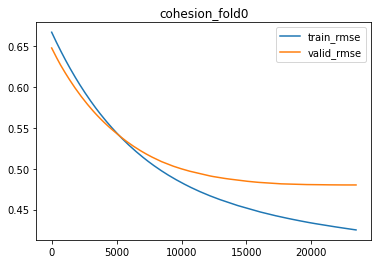

KeyError: 1

<Figure size 432x288 with 0 Axes>

In [43]:
LOGGER.info(f'Model: "stacking_lgbm" Score: {score:<.4f}  Scores: {scores}')
for t in CFG.target_cols:
    for fold in range(train.fold.nunique()):
        fig = plt.figure()
        plt.plot(results[t][fold]["training"]["rmse"],label="train_rmse")
        plt.plot(results[t][fold]["valid_1"]["rmse"],label="valid_rmse")
        plt.title(f"{t}_fold{fold}")
        plt.legend()
        plt.show()

In [44]:
import lightgbm as lgb
import joblib


params = {
    'task': 'train',              # タスクを訓練に設定
    'boosting_type': 'gbdt',      # GBDTを指定
    'objective': 'regression',    # 回帰を指定
    'metric': 'rmse',             # 回帰の損失（誤差）
    'learning_rate': 0.0001,         # 学習率
    'seed': 99,                  # シード値
    'device':'gpu',
    "num_boost_round":100000,
    "early_stopping_rounds":300,
    'max_depth':9,
      }

best_params = dict()
pred_cols2 = []
results = dict()
for t in CFG.target_cols:
    lgb_results = dict()
    for fold in range(train.fold.nunique()):
        pred_cols = [f"{t}_pred_{i}" for i in range(model_num) for t in CFG.target_cols]

        train_set = lgb.Dataset(train.loc[train.fold!=fold,pred_cols]\
                                    ,train.loc[train.fold!=fold,t])
        val_set = lgb.Dataset(train.loc[train.fold==fold,pred_cols]\
                                    ,train.loc[train.fold==fold,t])
        # Train and evaluate
        lgb_result = {} 
        model = lgb.train(
          params, 
          train_set, 
          #num_boost_round = 100000, # 10000 
          #early_stopping_rounds = 300, 
          valid_sets = [train_set, val_set], 
          verbose_eval = 1000,
          evals_result = lgb_result,
        )
        lgb_results[fold] = lgb_result
        best_params[fold] = model.params
        model_path = OUTPUT_DIR+f"lgb_fold{fold}.pkl"
        joblib.dump(model, model_path)
        tt = joblib.load(model_path)
        
        preds = tt.predict(train.loc[train.fold==fold,pred_cols])
        preds = np.clip(preds,1,5)
        train.loc[train.fold==fold,f"pred_{t}"] = preds
        break
    pred_cols2.append(f"pred_{t}")
    results[t] = lgb_results
    break
train.to_pickle(OUTPUT_DIR+f'oof_df.pkl')   
score, scores = get_score(train[pred_cols2].to_numpy(), train[CFG.target_cols].to_numpy())
LOGGER.info(f'Model: "stacking_lgbm" Score: {score:<.4f}  Scores: {scores}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 10710
[LightGBM] [Info] Number of data points in the train set: 2933, number of used features: 42
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 42 dense feature groups (0.12 MB) transferred to GPU in 0.000804 secs. 0 sparse feature groups
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 3.122741
Training until validation scores don't improv

Model: "stacking_lgbm" Score: 0.4862  Scores: [0.48619612444655635]


Model: "stacking_lgbm" Score: 0.4862  Scores: [0.48619612444655635]


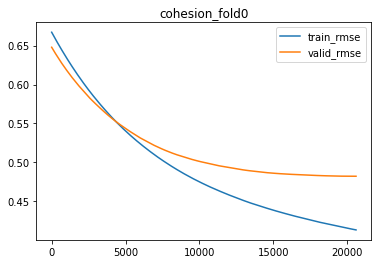

KeyError: 1

<Figure size 432x288 with 0 Axes>

In [45]:
LOGGER.info(f'Model: "stacking_lgbm" Score: {score:<.4f}  Scores: {scores}')
for t in CFG.target_cols:
    for fold in range(train.fold.nunique()):
        fig = plt.figure()
        plt.plot(results[t][fold]["training"]["rmse"],label="train_rmse")
        plt.plot(results[t][fold]["valid_1"]["rmse"],label="valid_rmse")
        plt.title(f"{t}_fold{fold}")
        plt.legend()
        plt.show()

In [46]:
import lightgbm as lgb
import joblib


params = {
    'task': 'train',              # タスクを訓練に設定
    'boosting_type': 'gbdt',      # GBDTを指定
    'objective': 'regression',    # 回帰を指定
    'metric': 'rmse',             # 回帰の損失（誤差）
    'learning_rate': 0.0001,         # 学習率
    'seed': 99,                  # シード値
    'device':'gpu',
    "num_boost_round":100000,
    "early_stopping_rounds":300,
    'max_depth':11,
      }

best_params = dict()
pred_cols2 = []
results = dict()
for t in CFG.target_cols:
    lgb_results = dict()
    for fold in range(train.fold.nunique()):
        pred_cols = [f"{t}_pred_{i}" for i in range(model_num) for t in CFG.target_cols]

        train_set = lgb.Dataset(train.loc[train.fold!=fold,pred_cols]\
                                    ,train.loc[train.fold!=fold,t])
        val_set = lgb.Dataset(train.loc[train.fold==fold,pred_cols]\
                                    ,train.loc[train.fold==fold,t])
        # Train and evaluate
        lgb_result = {} 
        model = lgb.train(
          params, 
          train_set, 
          #num_boost_round = 100000, # 10000 
          #early_stopping_rounds = 300, 
          valid_sets = [train_set, val_set], 
          verbose_eval = 1000,
          evals_result = lgb_result,
        )
        lgb_results[fold] = lgb_result
        best_params[fold] = model.params
        model_path = OUTPUT_DIR+f"lgb_fold{fold}.pkl"
        joblib.dump(model, model_path)
        tt = joblib.load(model_path)
        
        preds = tt.predict(train.loc[train.fold==fold,pred_cols])
        preds = np.clip(preds,1,5)
        train.loc[train.fold==fold,f"pred_{t}"] = preds
        break
    pred_cols2.append(f"pred_{t}")
    results[t] = lgb_results
    break
train.to_pickle(OUTPUT_DIR+f'oof_df.pkl')   
score, scores = get_score(train[pred_cols2].to_numpy(), train[CFG.target_cols].to_numpy())
LOGGER.info(f'Model: "stacking_lgbm" Score: {score:<.4f}  Scores: {scores}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 10710
[LightGBM] [Info] Number of data points in the train set: 2933, number of used features: 42
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 42 dense feature groups (0.12 MB) transferred to GPU in 0.000841 secs. 0 sparse feature groups
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 3.122741
Training until validation scores don't improv

Model: "stacking_lgbm" Score: 0.4861  Scores: [0.4861395037103055]


# グリッドサーチ
- fold0のcohesionをチューニング
- https://zenn.dev/mosamosa/articles/07d0076c9292136a3639

In [70]:
base_param = {
            'task': 'train',              # タスクを訓練に設定
            'boosting_type': 'gbdt',      # GBDTを指定
            'objective': 'regression',    # 回帰を指定
            'metric': 'rmse',             # 回帰の損失（誤差）
            'learning_rate': 0.0001,         # 学習率
            'seed': 99,                  # シード値
            'device':'gpu',
            "num_boost_round":100000,
            "early_stopping_rounds":300,
            'max_depth':13,
              }
params = []
for num_leaves in [7,15,31]:
    for max_depth in [5,7,9]:
        for min_data_in_leaf in [20,30,50]:
            base_param["num_leaves"] = num_leaves
            base_param["max_depth"] = max_depth
            base_param["min_data_in_leaf"] = min_data_in_leaf
            params.append(base_param)

In [72]:
import lightgbm as lgb
import joblib

best_params = dict()
pred_cols2 = []
results = dict()
scores_fold0 = []
for param in params:
    for t in CFG.target_cols:
        lgb_results = dict()
        for fold in range(train.fold.nunique()):
            pred_cols = [f"{t}_pred_{i}" for i in range(model_num) for t in CFG.target_cols]

            train_set = lgb.Dataset(train.loc[train.fold!=fold,pred_cols]\
                                        ,train.loc[train.fold!=fold,t])
            val_set = lgb.Dataset(train.loc[train.fold==fold,pred_cols]\
                                        ,train.loc[train.fold==fold,t])
            # Train and evaluate
            lgb_result = {} 
            model = lgb.train(
              param, 
              train_set, 
              #num_boost_round = 100000, # 10000 
              #early_stopping_rounds = 300, 
              valid_sets = [train_set, val_set], 
              verbose_eval = 1000,
              evals_result = lgb_result,
            )
            lgb_results[fold] = lgb_result
            best_params[fold] = model.params
            model_path = OUTPUT_DIR+f"lgb_fold{fold}.pkl"
            joblib.dump(model, model_path)
            tt = joblib.load(model_path)

            preds = tt.predict(train.loc[train.fold==fold,pred_cols])
            preds = np.clip(preds,1,5)
            train.loc[train.fold==fold,f"pred_{t}"] = preds
            break
        pred_cols2.append(f"pred_{t}")
        results[t] = lgb_results
        score, scores = get_score(train["pred_cohesion"].to_numpy().reshape(-1,1)\
                                  , train["cohesion"].to_numpy().reshape(-1,1))
        scores_fold0.append(score)
        break

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 10710
[LightGBM] [Info] Number of data points in the train set: 2933, number of used features: 42
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 42 dense feature groups (0.12 MB) transferred to GPU in 0.000970 secs. 0 sparse feature groups
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 3.122741
Training until validation scores don't improv

In [73]:
scores_fold0

[0.4858312751496472,
 0.48571726285752076,
 0.48570368775565675,
 0.4858145876624327,
 0.485844797902788,
 0.4858773577222502,
 0.4858963333295794,
 0.48582420028722617,
 0.48583572377409834,
 0.4858701202282629,
 0.48580839108820406,
 0.4858051645166063,
 0.4858622527547047,
 0.48579225345519933,
 0.4857388818378171,
 0.48576393862441175,
 0.48579684782916527,
 0.48573414980631546,
 0.48575579334820906,
 0.4857654165910178,
 0.4858280299597575,
 0.48575818639967144,
 0.4857615952573881,
 0.48576903663281384,
 0.4858250148434099,
 0.4858392376480403,
 0.48582895857940694]